In [41]:
library(MASS)
library(dplyr)
library(rpart)
library(ggplot2)
library(randomForest)
library(class)
library(caTools)
library(caret)
library(tidyverse)
library(magrittr)
library("e1071")
library(rpart.plot)
library('gmodels')

Warning message:
"package 'gmodels' was built under R version 3.6.1"

In [15]:
install.packages('rpart.plot')

package 'rpart.plot' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\colto\AppData\Local\Temp\RtmpQfA2dw\downloaded_packages


In [40]:
install.packages('gmodels')

also installing the dependencies 'gtools', 'gdata'



package 'gtools' successfully unpacked and MD5 sums checked
package 'gdata' successfully unpacked and MD5 sums checked
package 'gmodels' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\colto\AppData\Local\Temp\RtmpQfA2dw\downloaded_packages


In [6]:
list.files(path = "../input")

character(0)

In [9]:
# read dataset
student_grades = read.csv("StudentsPerformance.csv")

# check readability of file
str(student_grades)
# check summary statistics
summary(student_grades)

'data.frame':	1000 obs. of  8 variables:
 $ gender                     : Factor w/ 2 levels "female","male": 1 1 1 2 2 1 1 2 2 1 ...
 $ race.ethnicity             : Factor w/ 5 levels "group A","group B",..: 2 3 2 1 3 2 2 2 4 2 ...
 $ parental.level.of.education: Factor w/ 6 levels "associate's degree",..: 2 5 4 1 5 1 5 5 3 3 ...
 $ lunch                      : Factor w/ 2 levels "free/reduced",..: 2 2 2 1 2 2 2 1 1 1 ...
 $ test.preparation.course    : Factor w/ 2 levels "completed","none": 2 1 2 2 2 2 1 2 1 2 ...
 $ math.score                 : int  72 69 90 47 76 71 88 40 64 38 ...
 $ reading.score              : int  72 90 95 57 78 83 95 43 64 60 ...
 $ writing.score              : int  74 88 93 44 75 78 92 39 67 50 ...


    gender    race.ethnicity     parental.level.of.education          lunch    
 female:518   group A: 89    associate's degree:222          free/reduced:355  
 male  :482   group B:190    bachelor's degree :118          standard    :645  
              group C:319    high school       :196                            
              group D:262    master's degree   : 59                            
              group E:140    some college      :226                            
                             some high school  :179                            
 test.preparation.course   math.score     reading.score    writing.score   
 completed:358           Min.   :  0.00   Min.   : 17.00   Min.   : 10.00  
 none     :642           1st Qu.: 57.00   1st Qu.: 59.00   1st Qu.: 57.75  
                         Median : 66.00   Median : 70.00   Median : 69.00  
                         Mean   : 66.09   Mean   : 69.17   Mean   : 68.05  
                         3rd Qu.: 77.00   3rd Qu.: 79.00   3

[1] "Training set observations:  667"
[1] "Testing set observations:  333"


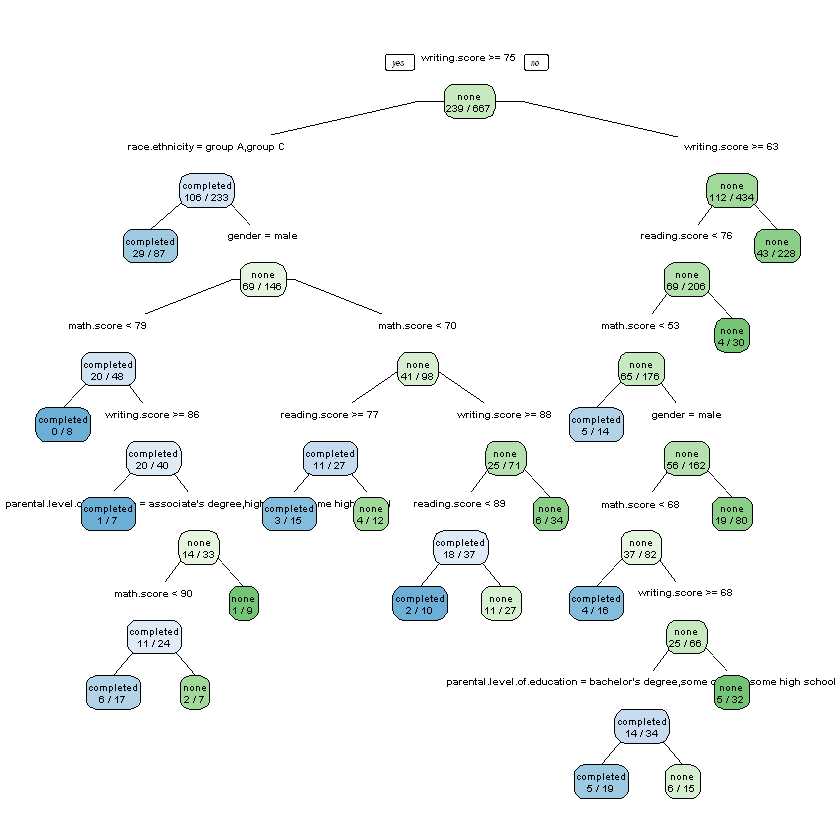

In [17]:
set.seed(1234)

# partition data
index= createDataPartition(student_grades$test.preparation.course, p= 2/3, list= FALSE)

grades_train= student_grades[index,]
grades_test= student_grades[-index,]

print(paste("Training set observations: ", nrow(grades_train)))
print(paste("Testing set observations: ", nrow(grades_test)))


#MODEL 1 = Single Decision Tree 

single_decision_tree_model= rpart(test.preparation.course ~., method = "class", data = grades_train)
rpart.plot(single_decision_tree_model,type = 1,extra= 3, fallen.leaves= FALSE,clip.facs= FALSE,faclen= 0, cex = 0.5,xlim= c(0, 1),ylim= c(0, 1))

In [18]:
"By the looks of this visualized tree, it does not seem like 
a good model since the tree is too long and 
hard to understand, lets see if creating a 
Random forest model provides more insights"

[1] "By the looks of this visualized tree, it does not seem like \na good model since the tree is too long and \nhard to understand, lets see if creating a \nRandom forest model provides more insights"

In [19]:
# Evaluation of Single Decision Tree

evaluation <- function(single_decision_tree_model, grades_train, atype) {
  cat("\nConfusion matrix:\n")
  prediction = predict(single_decision_tree_model, grades_train, type=atype)
  xtab = table(prediction, grades_train$test.preparation.course)
  print(xtab)
  cat("\nEvaluation:\n\n")
  accuracy = sum(prediction == grades_train$test.preparation.course)/length(grades_train$test.preparation.course)
  precision = xtab[1,1]/sum(xtab[,1])
  recall = xtab[1,1]/sum(xtab[1,])
  f = 2 * (precision * recall) / (precision + recall)
  cat(paste("Accuracy:\t", format(accuracy, digits=2), "\n",sep=" "))
  cat(paste("Precision:\t", format(precision, digits=2), "\n",sep=" "))
  cat(paste("Recall:\t\t", format(recall, digits=2), "\n",sep=" "))
  cat(paste("F-measure:\t", format(f, digits=2), "\n",sep=" "))
}
evaluation(single_decision_tree_model, grades_test, "class")


Confusion matrix:
           
prediction  completed none
  completed        56   37
  none             63  177

Evaluation:

Accuracy:	 0.7 
Precision:	 0.47 
Recall:		 0.6 
F-measure:	 0.53 


In [20]:
"Model 2 = Random Forest
For this second model I will attempt to better the 
quality of our dataset with the goal of improving 
the accuracy of predicting whether a student took 
the prep course based on their testing scores. For 
this I will remove certain features 
(race.ethnicity, lunch, parental.level.of.education) 
and create a new data frame that will 
only have 4 features and leave the class 
variable as test.preparation.course. Then I will remove 
extreme outlier observations for students that scored lower 
than the IQR of each subject"

[1] "Model 2 = Random Forest\nFor this second model I will attempt to better the \nquality of our dataset with the goal of improving \nthe accuracy of predicting whether a student took \nthe prep course based on their testing scores. For \nthis I will remove certain features \n(race.ethnicity, lunch, parental.level.of.education) \nand create a new data frame that will \nonly have 4 features and leave the class \nvariable as test.preparation.course. Then I will remove \nextreme outlier observations for students that scored lower \nthan the IQR of each subject"

In [21]:
# Feature Reduction
# new data frame for random forest model
student_grades2 = student_grades

drop = c("race.ethnicity","parental.level.of.education","lunch")
student_grades3 = student_grades2[,!(names(student_grades2) %in% drop)] 

str(student_grades3)

'data.frame':	1000 obs. of  5 variables:
 $ gender                 : Factor w/ 2 levels "female","male": 1 1 1 2 2 1 1 2 2 1 ...
 $ test.preparation.course: Factor w/ 2 levels "completed","none": 2 1 2 2 2 2 1 2 1 2 ...
 $ math.score             : int  72 69 90 47 76 71 88 40 64 38 ...
 $ reading.score          : int  72 90 95 57 78 83 95 43 64 60 ...
 $ writing.score          : int  74 88 93 44 75 78 92 39 67 50 ...


In [22]:
# Remove outlier observations
# here I will try to find a benchmark (as a cut off point) and 
#remove any students from the dataset that 
#scored less than this benchmark
summary(student_grades3$math.score)
math_bench= 57- 1.5 *IQR(student_grades3$math.score)


summary(student_grades3$reading.score)
reading_bench=59- 1.5 * IQR(student_grades3$reading.score)


summary(student_grades3$writing.score)
writing_bench= 57.75 - 1.5*IQR(student_grades3$writing.score)


print(paste("Math benchmark is: ", math_bench))
print(paste("Reading benchmark is: ", reading_bench))
print(paste("Writing benchmark is: ", writing_bench))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   57.00   66.00   66.09   77.00  100.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  17.00   59.00   70.00   69.17   79.00  100.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10.00   57.75   69.00   68.05   79.00  100.00 

[1] "Math benchmark is:  27"
[1] "Reading benchmark is:  29"
[1] "Writing benchmark is:  25.875"


In [23]:
cleansed_grades=
student_grades3 %>%
  filter(reading.score >= 29) %>%
  filter(writing.score >=25.875) %>%
  filter(math.score >=27) %>%
  select(gender:writing.score)

# check summary stats of the new cleansed data frame for each test score
summary(cleansed_grades$reading.score)
summary(cleansed_grades$writing.score)
summary(cleansed_grades$math.score)

print(paste("Data Frame with outliers: ",nrow(student_grades3)))
print(paste("Data Frame w/o outliers: ",nrow(cleansed_grades)))
print(paste("Number of students removed: ", nrow(student_grades3)- nrow(cleansed_grades)))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  29.00   60.00   70.00   69.64   80.00  100.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  27.00   58.00   69.00   68.57   79.00  100.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  27.00   57.00   66.00   66.63   77.00  100.00 

[1] "Data Frame with outliers:  1000"
[1] "Data Frame w/o outliers:  988"
[1] "Number of students removed:  12"


In [24]:
"Now that we have removed our 12 
outlier students lets re-do the data 
partitioning of our new cleansed data frame"

[1] "Now that we have removed our 12 \noutlier students lets re-do the data \npartitioning of our new cleansed data frame"

In [25]:
index2= createDataPartition(cleansed_grades$test.preparation.course, p= 2/3, list= FALSE)

grades_train2= cleansed_grades[index2,]
grades_test2= cleansed_grades[-index2,]

# check 
str(grades_train2) 
str(grades_test2)

'data.frame':	659 obs. of  5 variables:
 $ gender                 : Factor w/ 2 levels "female","male": 1 2 2 1 2 1 2 1 1 2 ...
 $ test.preparation.course: Factor w/ 2 levels "completed","none": 2 2 2 1 2 2 2 2 2 2 ...
 $ math.score             : int  72 47 76 88 40 38 40 65 69 88 ...
 $ reading.score          : int  72 57 78 95 43 60 52 81 75 89 ...
 $ writing.score          : int  74 44 75 92 39 50 43 73 78 86 ...
'data.frame':	329 obs. of  5 variables:
 $ gender                 : Factor w/ 2 levels "female","male": 1 1 1 2 2 2 1 1 2 2 ...
 $ test.preparation.course: Factor w/ 2 levels "completed","none": 1 2 2 1 2 1 2 2 2 2 ...
 $ math.score             : int  69 90 71 64 58 78 50 54 73 69 ...
 $ reading.score          : int  90 95 83 64 54 72 53 58 74 54 ...
 $ writing.score          : int  88 93 78 67 52 70 58 61 72 55 ...


In [26]:
Controlparameters= trainControl(method = "cv", number = 5, savePredictions = TRUE, classProbs = TRUE)

## specify mtry to build random forest--> will put this parameter in the model in the trControl arguement

parameter_grid= expand.grid(mtry=c(2,3,4))

random_forest_model= train(test.preparation.course ~., data = grades_train2, method= "rf",
                   trControl= Controlparameters, tuneGrid= parameter_grid)

# look at model results
random_forest_model

Random Forest 

659 samples
  4 predictor
  2 classes: 'completed', 'none' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 527, 526, 528, 527, 528 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
  2     0.6524447  0.2062076
  3     0.6478532  0.2049435
  4     0.6417582  0.1917846

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.

In [27]:
# EVALUATION OF RANDOM FOREST
rand_forest_predictions= predict(random_forest_model, grades_test2)
rand_forest_predictions
rand_forest_table= table(predictions= rand_forest_predictions, actual= grades_test2$test.preparation.course)
rand_forest_table

rf_test_accuracy= sum(diag(rand_forest_table)/sum(rand_forest_table))
 
print(paste("Random Forest accuracy:", round(rf_test_accuracy *100),"%"))

[1] completed none      none      completed none      completed completed
  [8] none      none      none      none      none      none      completed
 [15] none      none      completed none      none      none      none     
 [22] none      none      completed none      none      none      completed
 [29] none      completed none      none      completed none      none     
 [36] none      completed none      none      completed completed none     
 [43] none      none      none      none      completed none      completed
 [50] completed completed none      none      completed completed none     
 [57] completed completed none      completed completed none      completed
 [64] none      completed none      completed none      completed completed
 [71] none      completed none      none      none      none      completed
 [78] none      completed none      none      completed completed none     
 [85] none      none      none      none      completed none      completed
 [92] none      completed none      none      none      completed none     
 [99] completed none      completed completed none      none      none     
[106] none      completed none      none      none      none      none     
[113] none      none      none      completed none      completed none     
[120] none      completed none      none      none      completed none     
[127] completed none      none      none      completed none      none     
[134] none      none      none      none      none      none      none     
[141] completed none      completed none      none      none      none     
[148] completed none      completed none      none      none      none     
[155] completed completed completed none      none      none      none     
[162] completed completed completed completed completed none      none     
[169] none      completed none      none      none      none      completed
[176] none      none      completed completed completed none      completed
[183] none      none      completed completed completed none      none     
[190] none      none      none      none      completed none      none     
[197] none      completed none      none      completed none      none     
[204] none      none      completed none      completed completed none     
[211] completed none      completed completed completed none      none     
[218] completed none      completed none      none      completed none     
[225] none      none      completed none      none      completed none     
[232] none      none      completed none      completed completed none     
[239] none      completed none      completed completed none      none     
[246] none      completed none      completed none      completed none     
[253] completed none      none      none      completed none      none     
[260] none      none      none      none      none      none      completed
[267] none      completed none      none      completed none      completed
[274] none      completed none      none      none      none      none     
[281] completed completed none      none      none      none      none     
[288] none      none      completed none      none      none      none     
[295] none      none      none      none      none      none      completed
[302] none      none      completed completed completed none      none     
[309] none      none      none      none      none      none      none     
[316] none      none      none      none      completed none      completed
[323] none      none      completed completed none      none      completed
Levels: completed none

           actual
predictions completed none
  completed        62   49
  none             57  161

[1] "Random Forest accuracy: 68 %"


In [28]:
"By the looks of this analysis I can conclude that this dataset 
may not be fitting well to this type of classification algorithm.
Maybe using another classification method would help improve our results."

[1] "By the looks of this analysis I can conclude that this dataset \nmay not be fitting well to this type of classification algorithm.\nMaybe using another classification method would help improve our results."

In [31]:
"Model 3 = K-Nearest Neighbor Model"

"For this I will create a new data frame only containing gender, 
reading.score and math.score. And will remove these variable from 
the data frame we removed outliers from, cleansed_grades"

[1] "Model 3 = K-Nearest Neighbor Model"

[1] "For this I will create a new data frame only containing gender, \nreading.score and math.score. And will remove these variable from \nthe data frame we removed outliers from... cleansed_grades"

In [32]:
# create copy of original cleansed_grades data frame
cleansed_grades2 = cleansed_grades

#remove all other features except for gender, reading.score, math.score
drop = c("test.preparation.course","writing.score")
cleansed_grades3 = cleansed_grades2[,!(names(cleansed_grades2) %in% drop)] 

#check structure of new data frame
str(cleansed_grades3)

'data.frame':	988 obs. of  3 variables:
 $ gender       : Factor w/ 2 levels "female","male": 1 1 1 2 2 1 1 2 2 1 ...
 $ math.score   : int  72 69 90 47 76 71 88 40 64 38 ...
 $ reading.score: int  72 90 95 57 78 83 95 43 64 60 ...


In [33]:
"For this algorithm to work I will change the class label to factor type"

[1] "For this algorithm to work I will change the class label to factor type"

In [34]:
as.factor(cleansed_grades3$gender)

#check data type change
class(cleansed_grades3$gender)

[1] female female female male   male   female female male   male   female
 [11] male   male   female male   female female male   male   female male  
 [21] female male   female male   male   male   female male   female female
 [31] female female male   male   male   female female female male   male  
 [41] female female male   female male   female female female male   male  
 [51] male   male   male   female female female male   male   male   male  
 [61] male   female female male   male   female male   female female male  
 [71] female male   male   male   male   female female female male   male  
 [81] male   male   female female female female female female male   male  
 [91] male   female male   male   female female female male   male   female
[101] male   male   female female male   female female female male   male  
[111] female female male   female female female female female male   female
[121] male   male   female male   male   male   female male   male   male  
[131] female male   male   male   male   female male   female female female
[141] male   male   male   male   female male   male   male   female male  
[151] male   female female male   female male   male   female male   male  
[161] female female male   female female female male   male   female female
[171] female female female female female female male   female female female
[181] male   male   male   male   male   female female male   female male  
[191] female male   male   male   female female female female male   female
[201] male   male   male   male   female female male   female male   male  
[211] male   female female male   male   female male   female male   female
[221] female female male   male   female male   male   female male   male  
[231] male   male   female male   male   male   female female male   male  
[241] male   male   female female male   male   female female male   male  
[251] female female male   female female female male   female female male  
[261] male   female female female female male   male   female female male  
[271] male   female female female male   male   male   female female female
[281] male   male   female male   male   male   male   male   female male  
[291] male   male   male   male   male   male   male   female male   female
[301] male   male   male   female female female male   male   female female
[311] male   female male   male   female female female female female female
[321] female male   male   female male   male   male   male   female female
[331] male   male   female male   female female male   male   female male  
[341] female male   male   female male   female female female female male  
[351] female male   female female male   female female male   male   male  
[361] male   female female male   female male   female female male   female
[371] female female male   female male   male   female female female female
[381] female female male   male   female male   male   female male   female
[391] female male   male   female male   female female female female male  
[401] female female male   female male   male   male   female male   male  
[411] male   male   male   female female female female male   female male  
[421] male   male   male   male   female male   female male   male   male  
[431] male   male   male   female female female female male   female male  
[441] male   male   male   female female female male   female male   female
[451] male   female male   male   male   female female male   female male  
[461] female male   female female female female female female male   male  
[471] female male   male   female male   male   female male   male   female
[481] male   male   female female female female female male   female female
[491] female male   female female male   female female female male   male  
[501] male   female male   male   male   female female female female female
[511] female female male   female male   male   male   male   male   female
[521] female female female female male   female ma

[1] "factor"

In [35]:
# will re-do data partitions once again with reduced feature data frame
index3= createDataPartition(cleansed_grades3$gender, p= 2/3, list= FALSE)

grades_train3= cleansed_grades3[index3,]
grades_test3= cleansed_grades3[-index3,]

# check 
str(grades_train3) 
str(grades_test3)

'data.frame':	659 obs. of  3 variables:
 $ gender       : Factor w/ 2 levels "female","male": 1 1 1 2 1 1 2 2 2 1 ...
 $ math.score   : int  72 69 90 76 71 88 40 64 40 65 ...
 $ reading.score: int  72 90 95 78 83 95 43 64 52 81 ...
'data.frame':	329 obs. of  3 variables:
 $ gender       : Factor w/ 2 levels "female","male": 2 1 2 1 1 1 1 1 2 2 ...
 $ math.score   : int  47 38 58 50 69 69 69 63 40 81 ...
 $ reading.score: int  57 60 54 53 75 73 74 65 42 81 ...


In [36]:
# will create 2 subsets of data frames for both the training and testing sets
# 2 subsets for training, one containing only the class labels and the other containing only the variables without the class labels
grades_train3_wo_labels= subset(grades_train3, select= -gender)
grades_train3_w_labels= grades_train3$gender

#2 subsets for testing one containing only the class labels and the other containing only the variables without the class label
grades_test3_wo_labels= subset(grades_test3, select= -gender)
grades_test3_w_labels= grades_test3$gender

In [37]:
"To determine the best value of K I will take
the square root of 659 the number of observations in our training set"

[1] "To determine the best value of K I will take\nthe square root of 659 the number of observations in our training set"

In [38]:
print(paste("Best value for K, based on sqrt root of training set observations = ",sqrt(nrow(grades_train3))))

[1] "Best value for K, based on sqrt root of training set observations =  25.6709953059869"


In [42]:
# KNN Model

knn_model= knn(train = grades_train3_wo_labels, test= grades_test3_wo_labels, cl = grades_train3_w_labels, k = 25)

# view model
knn_model

# evaluate model
library(gmodels)
#CrossTable(x= cancer_test_labels, y= cancer_knn_model, prop.chisq= FALSE)

knn_evaluation = CrossTable(x= grades_test3_w_labels, y= knn_model, prop.chisq= FALSE)

knn_model_accuracy= (146 + 131)/329

print(paste("KNN Model accuracy= ", round(knn_model_accuracy * 100), "%"))

[1] female female male   male   female female female male   male   male  
 [11] female male   female female female female female female female female
 [21] male   male   female male   male   female female female male   male  
 [31] female male   male   male   female male   male   female female male  
 [41] male   male   male   female male   male   male   female female female
 [51] female female male   male   male   female female female female male  
 [61] female male   male   male   female male   male   female female female
 [71] male   male   male   male   male   male   female female female female
 [81] male   male   female male   female female male   male   male   male  
 [91] male   male   male   female female male   male   male   male   female
[101] female male   male   female male   male   female female female female
[111] male   female female female female female female male   female male  
[121] female female male   female female male   male   female female female
[131] male   male   female female male   male   male   female male   male  
[141] male   male   male   male   female male   male   female male   female
[151] female female male   male   male   female male   male   male   male  
[161] male   male   female male   male   female male   male   male   female
[171] female male   female female male   female male   female male   male  
[181] female male   female male   male   female female male   female female
[191] male   female female female male   female female female female female
[201] male   male   female male   male   male   female female male   female
[211] male   male   female female male   female female female female female
[221] female female female female female male   female male   female female
[231] female male   male   male   male   female female female male   male  
[241] male   female male   female male   female female male   male   male  
[251] male   male   female male   female male   female male   female male  
[261] female female female female female female female female male   female
[271] female male   male   female female female male   female male   male  
[281] female male   female female female male   female female female male  
[291] female male   female male   male   female male   male   female female
[301] female female female male   female male   male   female female female
[311] female female female male   male   female female female male   male  
[321] female female female female female female male   male   male  
Levels: female male


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  329 

 
                      | knn_model 
grades_test3_w_labels |    female |      male | Row Total | 
----------------------|-----------|-----------|-----------|
               female |       146 |        24 |       170 | 
                      |     0.859 |     0.141 |     0.517 | 
                      |     0.839 |     0.155 |           | 
                      |     0.444 |     0.073 |           | 
----------------------|-----------|-----------|-----------|
                 male |        28 |       131 |       159 | 
                      |     0.176 |     0.824 |     0.483 | 
                      |     0.161 |     0.845 |           | 
                      |     0.085 |     0.398 |           | 
----------------------|-----------|-----------|-----------|
       

In [43]:
"With this model we are able to correctly predict 
with 84% accuracy whether a student is male or female by 
looking at their math and reading scores."

[1] "With this model we are able to correctly predict \nwith 84% accuracy whether a student is male or female by \nlooking at their math and reading scores."